In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from geopy.geocoders import Nominatim
from tqdm import tqdm
from geopy.distance import geodesic
import folium
from folium.plugins import MarkerCluster
import math
import datetime
import geopandas as gpd
import urllib.request
import requests
import json
import openmeteo_requests
import requests_cache
from shapely.geometry import Polygon, Point
from retry_requests import retry
from shapely.wkt import loads
import random 
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn import metrics
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import svm

# XGBoost

In [ ]:
# XGBOOST
from sklearn.model_selection import train_test_split
import warnings
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.metrics import accuracy_score
import numpy as np


warnings.filterwarnings("ignore")

# DATA PATHS
POSITIVES_PATH = Path("final_data/buildings/positive_samples_buildings_200.csv")
NEGATIVES_PATH_TRUE = Path("final_data/buildings/negative_samples_buildings_200.csv")
NEGATIVES_PATH_FALSE = Path("final_data/buildings/TMP_negative_samples_buildings_200.csv")
NEGATIVES_PATH_RANDOM = Path("final_data/buildings/TMP3_negative_samples_buildings_200.csv")

# POSITIVE SAMPLE BUILDINGS
POSITIVES = pd.read_csv(POSITIVES_PATH)

# NEGATIVE SAMPLE BUILDINGS
NEGATIVES_TRUE = pd.read_csv(NEGATIVES_PATH_TRUE)
NEGATIVES_FALSE = pd.read_csv(NEGATIVES_PATH_FALSE)
NEGATIVES_RANDOM = pd.read_csv(NEGATIVES_PATH_RANDOM)

# OUTPUTS
POSITIVES['label'] = 1
NEGATIVES_TRUE['label'] = 0
NEGATIVES_FALSE['label'] = 0
NEGATIVES_RANDOM['label'] = 0

# COMMON COLUMNS
common_columns = ['grid_id', 'has_building', 'Gemiddeld Bouwjaar',
       'Gewogen Gemiddeld Bouwjaar', 'Voor 1860', '1860-1919', '1920-1939',
       '1940-1969', '1970-1985', '1986-2001', 'Na 2001', 'temperature_2m',
       'relative_humidity_2m', 'dew_point_2m', 'apparent_temperature',
       'precipitation', 'rain', 'snowfall', 'snow_depth', 'weather_code',
       'pressure_msl', 'surface_pressure', 'wind_speed_10m',
       'wind_direction_10m', 'wind_gusts_10m', 'soil_temperature_0_to_7cm',
       'soil_temperature_7_to_28cm', 'soil_temperature_28_to_100cm',
       'soil_temperature_100_to_255cm', 'soil_moisture_0_to_7cm',
       'soil_moisture_7_to_28cm', 'soil_moisture_28_to_100cm',
       'soil_moisture_100_to_255cm']

# CONCATENATE POSITIVES AND NEGATIVES
DATA = pd.concat([POSITIVES[common_columns + ['label']],
                  NEGATIVES_TRUE[common_columns + ['label']],
                  NEGATIVES_FALSE[common_columns + ['label']],
                  NEGATIVES_RANDOM[common_columns + ['label']]])
                  
DATA = DATA[['label'] + [col for col in DATA.columns if col != 'label']]

X, y = DATA.drop(['label',
                  'grid_id',
                  'Gemiddeld Bouwjaar'], axis=1), DATA[['label']]

cats = X.select_dtypes(exclude=np.number).columns.tolist()

for col in cats:
   X[col] = X[col].astype('category')

X = X[['has_building', 'Gewogen Gemiddeld Bouwjaar', 'wind_gusts_10m']]

# SPLIT THE DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# CREATE XGBoost DMatrix
dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test, y_test, enable_categorical=True)
evals = [(dtrain_clf, "train"), (dtest_clf, "validation")]

# DEFINING HYPERPARAMETERS
best_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "max_depth": 7,
    "learning_rate": 0.2, 
    "subsample": 1.0,
    "colsample_bytree": 0.8,
    "gamma": 0.2,
    "reg_alpha": 0.01,  
    "reg_lambda": 0  
}
n = 1000


# MODEL TRAINING
model = xgb.train(
    params=best_params,
    dtrain=dtrain_clf, 
    num_boost_round=n, 
    verbose_eval=250, 
    evals=evals,
    early_stopping_rounds=50
)

# PREDICTION WITH THE BEST MODEL
y_pred_clf = model.predict(dtest_clf)
y_pred_labels = (y_pred_clf > 0.5).astype(int)

# ACCURACY EVALUATION
accuracy = accuracy_score(y_test, y_pred_labels)
percentage_correct = accuracy * 100

# FEATURE IMPORTANCE PLOT
xgb.plot_importance(model, importance_type='gain')
plt.show()

print(f"Percentage of correctly classified labels: {percentage_correct:.2f}%")


In [168]:
import pickle

# Save the XGBoost model as a pickle file
with open("models/buildings/FINAL_xgboost_model_buildings.pkl", "wb") as model_file:
    pickle.dump(model, model_file)

# Print a message indicating that the model has been saved
print("XGBoost model saved successfully as a pickle file.")



XGBoost model saved successfully as a pickle file.


In [ ]:
# HYPERPARAMETER TUNING
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],  # L1 regularization
    'reg_lambda': [0, 0.01, 0.1]  # L2 regularization
}
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', n_estimators=100)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=2)
grid_search.fit(X_train, y_train)

print("Beste hyperparameters gevonden:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)



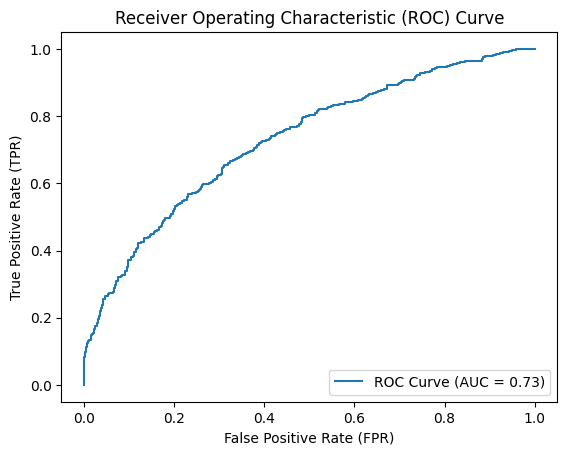

In [30]:
# ROC Curve
y_pred_clf = model.predict(dtest_clf)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_clf)
auc = metrics.roc_auc_score(y_test, y_pred_clf)
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(auc))
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc=4)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

# LOGISTIC REGRESSION

In [83]:
# INSTANTIATE THE MODEL
logreg = LogisticRegression(random_state=16)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [85]:
accuracy = accuracy_score(y_test, y_pred)
percentage_correct = accuracy * 100

print(f"Percentage of correctly classified labels: {percentage_correct:.2f}%")


Percentage of correctly classified labels: 63.96%


In [ ]:
# Assuming y_test and y_pred_clf are already defined
y_pred_clf = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_clf)
auc = metrics.roc_auc_score(y_test, y_pred_clf)

# Plotting the ROC curve
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(auc))
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc=4)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()


# SUPPORT VECTOR MACHINE (SVM)

In [91]:
# MODEL TRAINING
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [94]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.6521264994547438


# ENRICH GRIDS (RORY)

In [14]:
# BUILDINGS
GRIDS_TO_BE_ENRICHED_PATH = Path("final_data/grids/grids_to_be_enriched.csv")
grids = pd.read_csv(GRIDS_TO_BE_ENRICHED_PATH, sep=',', encoding='utf-8')
grids = grids.drop('Unnamed: 0', axis=1)
grids = grids.rename(columns={"id": "grid_id"})


GRIDS_ENRICHED_BUILDINGS_PATH = Path("data_gebouwen/grid_enriched_buildings_200.csv")
buildings = pd.read_csv(GRIDS_ENRICHED_BUILDINGS_PATH, sep=',', encoding='utf-8')
grids_enriched = grids.merge(buildings[['grid_id',
                                        'has_building',
                                        'Gemiddeld Bouwjaar',
                                        'Gewogen Gemiddeld Bouwjaar',
                                        'Na 2001',
                                        '1986-2001',
                                        '1970-1985',
                                        '1920-1939',
                                        '1860-1919',
                                        '1940-1969',
                                        'Voor 1860']])


grids_enriched
grids_enriched.to_csv('final_data/grids/grids_by_hand_enriched_buildings', sep=",", encoding="utf-8", index=False)


In [35]:
# roadsigns
GRIDS_TO_BE_ENRICHED_PATH = Path("final_data/grids/grids_to_be_enriched.csv")
grids = pd.read_csv(GRIDS_TO_BE_ENRICHED_PATH, sep=',', encoding='utf-8')
grids = grids.drop('Unnamed: 0', axis=1)
grids = grids.rename(columns={"id": "grid_id"})


GRIDS_ENRICHED_roadsigns_PATH = Path("data_roadsigns/grid_enriched_roadsigns_200.csv")
roadsigns = pd.read_csv(GRIDS_ENRICHED_roadsigns_PATH, sep=',', encoding='utf-8')
grids_enriched = grids.merge(roadsigns.iloc[:, [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]],
                             on='grid_id').drop('Unnamed: 0', axis=1)



grids_enriched
grids_enriched.to_csv('final_data/grids/grids_by_hand_enriched_roadsigns', sep=",", encoding="utf-8", index=False)